In [2]:
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
from scipy import stats
import operator
import matplotlib.pyplot as plt
import pickle
from sklearn import feature_selection
import random
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Matplotlib is building the font cache; this may take a moment.
/var/folders/rc/9nnf7t2j0px3pnf_5x6mrg6m0000gn/T/ipykernel_9528/3691525371.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [3]:
# name = 'Debias_scale_DropoutNet'
# name = 'Debias_scale_Heater'
# name = 'Debias_scale_DeepMusic'
# name = 'Debias_scale_KNN'
# name = 'Debias_gen_DropoutNet'
name = 'Debias_gen_Heater'
# name = 'Debias_gen_DeepMusic'
# name = 'Debias_gen_KNN'

In [4]:
item_new2old_list = np.load('./item_new2old_list_' + name + '.npy')
user_new2old_list = np.load('./user_new2old_list_' + name + '.npy')
rank_matrix = np.load('./rank_matrix_' + name + '.npy')

cold_test_df = pd.read_csv('./cold_test_df.csv')

item_genre_dict_all = None
with open('./item_genre_dict.pkl', 'rb') as f:
    item_genre_dict_all = pickle.load(f)
    
item_AS_list_all = np.load('./item_audience_size_list.npy')

user_cold_test_like = list(np.load('./user_cold_test_like.npy', allow_pickle=True))

In [5]:
# get the old id to new id convertion lists for users and items
item_old2new_id_dict = dict()
user_old2new_id_dict = dict()
for i in range(len(item_new2old_list)):
    item_old2new_id_dict[item_new2old_list[i]] = i
for u in range(len(user_new2old_list)):
    user_old2new_id_dict[user_new2old_list[u]] = u

In [6]:
# filter the item_genre_dict_all with items involed in test phase
item_genre_dict = dict()
genres = set()
for old_iid in item_genre_dict_all:
    if old_iid in item_old2new_id_dict:
        item_genre_dict[item_old2new_id_dict[old_iid]] = item_genre_dict_all[old_iid]
        genres = genres.union(set(item_genre_dict_all[old_iid]))
genres = list(genres)

In [7]:
# filter the item_AS_list_all with items involed in test phase
item_AS_list = np.zeros_like(item_new2old_list).astype(np.float32)
for i in range(len(item_AS_list_all)):
    if i in item_old2new_id_dict:
        item_AS_list[item_old2new_id_dict[i]] = item_AS_list_all[i]

In [8]:
# get cold_test_df with new id for user and item
userIds = cold_test_df['uid'].values
itemIds = cold_test_df['iid'].values
userIdsNew = copy.copy(userIds)
itemIdsNew = copy.copy(itemIds)
for i in range(len(userIds)):
    userIdsNew[i] = user_old2new_id_dict[userIds[i]]
    itemIdsNew[i] = item_old2new_id_dict[itemIds[i]]
cold_test_df = pd.DataFrame({'uid': userIdsNew, 'iid': itemIdsNew})

In [9]:
# get user_like_list for cold test
cold_test_like = [[] for _ in range(len(user_new2old_list))] 

for old_uid in tqdm(range(len(user_cold_test_like))):
    if old_uid in user_old2new_id_dict:
        old_test_like = user_cold_test_like[old_uid]
        test_like = []
        for old_iid in old_test_like:
            if old_iid in item_old2new_id_dict:
                test_like.append(item_old2new_id_dict[old_iid])
        cold_test_like[user_old2new_id_dict[old_uid]] = np.array(test_like).astype(int)
user_cold_test_like = cold_test_like

100%|██████████| 6018/6018 [00:00<00:00, 73396.42it/s]


In [10]:
k = 30

u_recall = np.zeros_like(user_new2old_list).astype(np.float32)
u_ndcg = np.zeros_like(user_new2old_list).astype(np.float32)

for u in tqdm(range(len(user_new2old_list))):
    u_rank_list = rank_matrix[u]
    u_cold_like_set = set(user_cold_test_like[u])
    
    u_like_set = u_cold_like_set
    
    n_like = len(u_like_set)

    recall_tmp = 0.
    ndcg_tmp = 0.
    ndcg_de_tmp = 0.
    for rank, iid in enumerate(u_rank_list):
        if rank == k:
            break
            
        if rank < n_like: 
            ndcg_de_tmp += (1. / np.log2(rank + 2))

        if iid in u_like_set:
            recall_tmp += 1.
            ndcg_tmp += (1. / np.log2(rank + 2))
            
    u_recall[u] = recall_tmp / len(u_like_set)
    u_ndcg[u] = ndcg_tmp / ndcg_de_tmp

print('recall@' + str(k) + ' = ' + str(np.mean(u_recall)))
print('ndcg@' + str(k) + ' = ' + str(np.mean(u_ndcg)))

100%|██████████| 6018/6018 [00:00<00:00, 32604.28it/s]

recall@30 = 0.35549837
ndcg@30 = 0.5205612


In [11]:
# count the rankings for matched users for each item 
k = 100

item_rank_count = np.zeros_like(item_AS_list)
item_attention_count = np.zeros_like(item_AS_list)
item_count = np.zeros_like(item_AS_list)

for u in tqdm(range(len(user_new2old_list))):
    u_rank_list = rank_matrix[u]
    u_cold_like_set = set(user_cold_test_like[u])
    
    u_like_set = u_cold_like_set
    
    n_like = len(u_like_set)
    
    match_item_set = set([])
    for rank, iid in enumerate(u_rank_list):
        if rank == k:
            break

        if iid in u_like_set:
            item_rank_count[iid] += (rank + 1)
            item_attention_count[iid] += (1. / np.log2(rank + 2))
            item_count[iid] += 1.
            match_item_set.add(iid)
            
    unmatch_item_set = u_like_set - match_item_set
    for iid in unmatch_item_set:
        item_rank_count[iid] += (k + 1)
        item_attention_count[iid] += 0.
        item_count[iid] += 1.

  0%|          | 0/6018 [00:00<?, ?it/s]

100%|██████████| 6018/6018 [00:00<00:00, 6917.29it/s]


In [12]:
# calculate average metrics for all items
item_avg_attention = item_attention_count / (item_count + 1e-7)

cold_idx = cold_test_df['iid'].unique()

item_cold_avg_attention = item_avg_attention[cold_idx]

# print('avg attention for all = ' + str(np.mean(item_avg_attention)))
print('avg attention for cold = ' + str(np.mean(item_cold_avg_attention)))

minority_10_n = int(len(item_avg_attention) * 0.1)
minority_20_n = int(len(item_avg_attention) * 0.2)
minority_30_n = int(len(item_avg_attention) * 0.3)

minority_10_idx = np.argpartition(item_avg_attention, minority_10_n)[:minority_10_n]
minority_20_idx = np.argpartition(item_avg_attention, minority_20_n)[:minority_20_n]
minority_30_idx = np.argpartition(item_avg_attention, minority_30_n)[:minority_30_n]

majority_10_idx = np.argpartition(item_avg_attention, -minority_10_n)[-minority_10_n:]
majority_20_idx = np.argpartition(item_avg_attention, -minority_20_n)[-minority_20_n:]
majority_30_idx = np.argpartition(item_avg_attention, -minority_30_n)[-minority_30_n:]

print('=' * 50)
print('$$ Minority 10% attention = ' + str(np.mean(item_avg_attention[minority_10_idx])))
print('$$ Minority 20% attention = ' + str(np.mean(item_avg_attention[minority_20_idx])))
print('$$ Minority 30% attention = ' + str(np.mean(item_avg_attention[minority_30_idx])))
print('=' * 50)
print('$$ Majority 10% attention = ' + str(np.mean(item_avg_attention[majority_10_idx])))
print('$$ Majority 20% attention = ' + str(np.mean(item_avg_attention[majority_20_idx])))
print('$$ Majority 30% attention = ' + str(np.mean(item_avg_attention[majority_30_idx])))

avg attention for cold = 0.071921505
$$ Minority 10% attention = 0.0073177223
$$ Minority 20% attention = 0.013640873
$$ Minority 30% attention = 0.019588483
$$ Majority 10% attention = 0.20359877
$$ Majority 20% attention = 0.16472134
$$ Majority 30% attention = 0.1416655


In [13]:
keep_idx = np.where(item_AS_list >= 10)[0]
cold_idx = cold_test_df['iid'].unique()
keep_idx = np.array(list(set(list(cold_idx)).intersection(set(list(keep_idx)))))
print('#all cold items in test:' + str(len(cold_idx)))
print('#filtered cold items in test:' + str(len(keep_idx)) + ' (' + str(len(keep_idx) / len(cold_idx)) + ')')

#all cold items in test:905
#filtered cold items in test:905 (1.0)


In [14]:
item_avg_attention = item_avg_attention[keep_idx]

[('IMAX', 0.1824600100517273), ('Animation', 0.1159609702528652), ('Fantasy', 0.10528463289873409), ('Sci-Fi', 0.10282835303697475), ('Adventure', 0.09939722048584372), ('Action', 0.09810292244289223), ('Western', 0.09674872549322362), ('Mystery', 0.09174640288369523), ('Film-Noir', 0.08898551312877852), ('Musical', 0.08512268369086087), ('War', 0.0847133825711139), ('Crime', 0.08277999211956437), ('Thriller', 0.08246827497513909), ('Children', 0.08157495678299004), ('Horror', 0.0762045070770438), ('Romance', 0.07281099148995934), ('Comedy', 0.07073551270443557), ('Drama', 0.06823351827074528), ('Documentary', 0.026294426864478738)]


/var/folders/rc/9nnf7t2j0px3pnf_5x6mrg6m0000gn/T/ipykernel_9528/3278475297.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels([''])


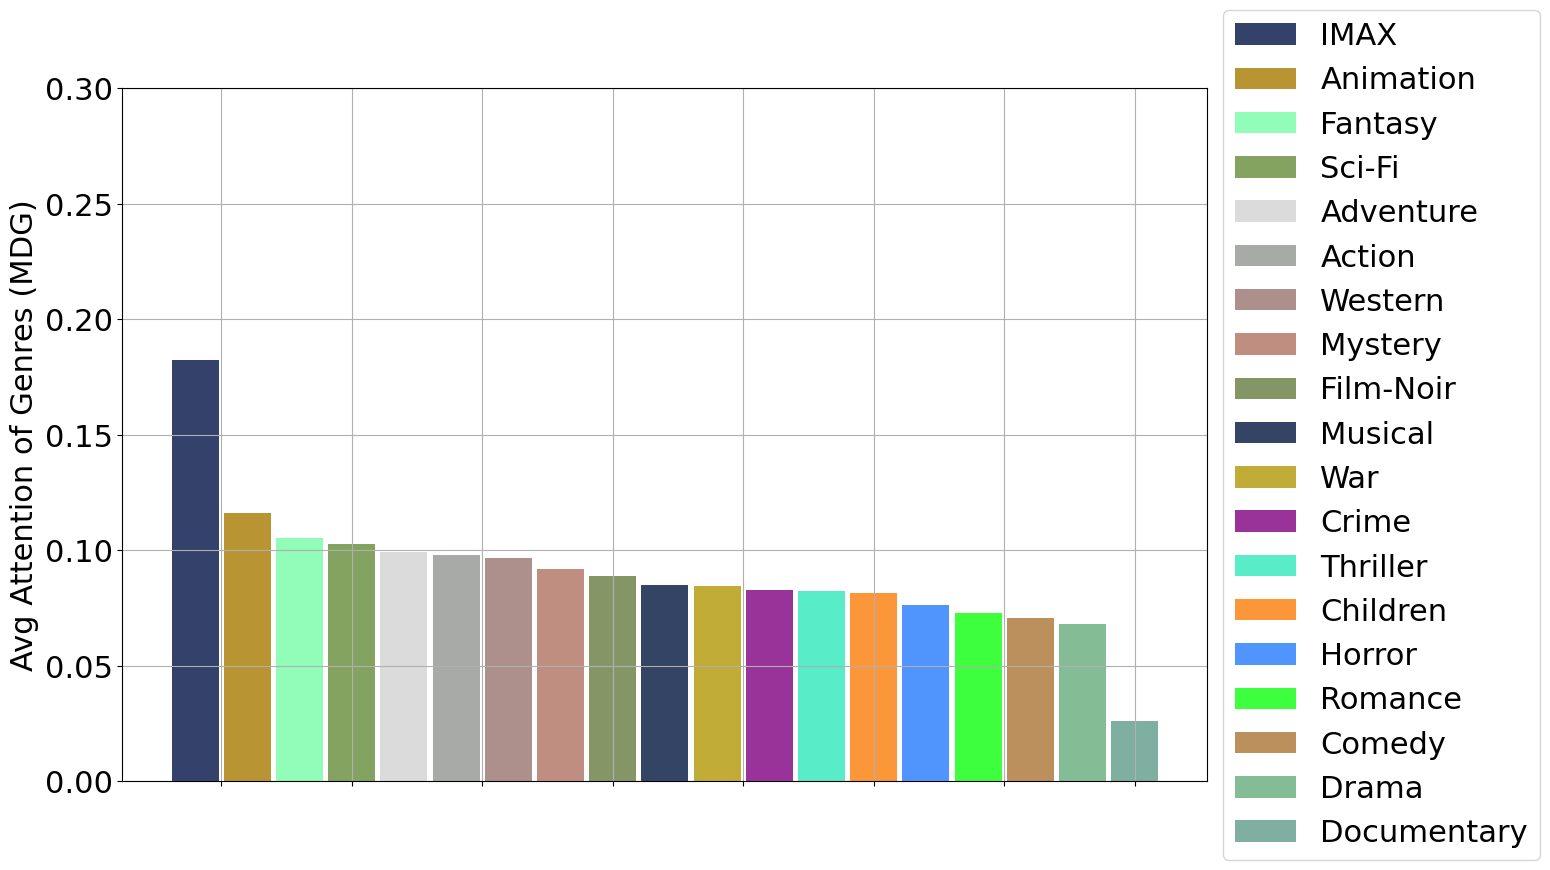

In [15]:
genre_avg_attention_dict = dict()
genre_count_dict = dict()
for g in genres:
    genre_avg_attention_dict[g] = 0.
    genre_count_dict[g] = 0.
for iid in keep_idx:
    i_genres = item_genre_dict[iid]
    i_avg_attention = item_avg_attention[iid]
    for g in i_genres:
        genre_avg_attention_dict[g] += i_avg_attention
        genre_count_dict[g] += 1.

for g in genres:
    count = genre_count_dict[g]
    genre_avg_attention_dict[g] /= count

genre_sorted = sorted(genre_avg_attention_dict.items(), key=operator.itemgetter(1), reverse=True)
print(genre_sorted)
genre_color_dict = dict()
import matplotlib.colors as colors
np.random.seed(0)
colors_list = list(colors._colors_full_map.values())
np.random.shuffle(colors_list)
for i in range(len(genre_sorted)):
    genres.append(genre_sorted[i][0])
    genre_color_dict[genre_sorted[i][0]] = colors_list[i]
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 9))
gap = 0.1
x = np.arange(1)  # the label locations
width = 1  # the width of the bars
start = 0.5 * (int(len(genre_sorted) + 1) % 2) + len(genre_sorted) - 1
position = np.arange(start, -1 * start - 1, -1)
for i in range(len(genre_sorted)):
    axes.bar(0 - width*position[i], genre_sorted[i][1], width-gap, label=genre_sorted[i][0], alpha=0.8, color=genre_color_dict[genre_sorted[i][0]])
axes.set_ylabel('Avg Attention of Genres (MDG)')
plt.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
axes.set_xticklabels([''])
# axes.set_title('DropoutNet')
axes.set_ylim(0, 0.3)
plt.grid(True)
fig.patch.set_facecolor('white')

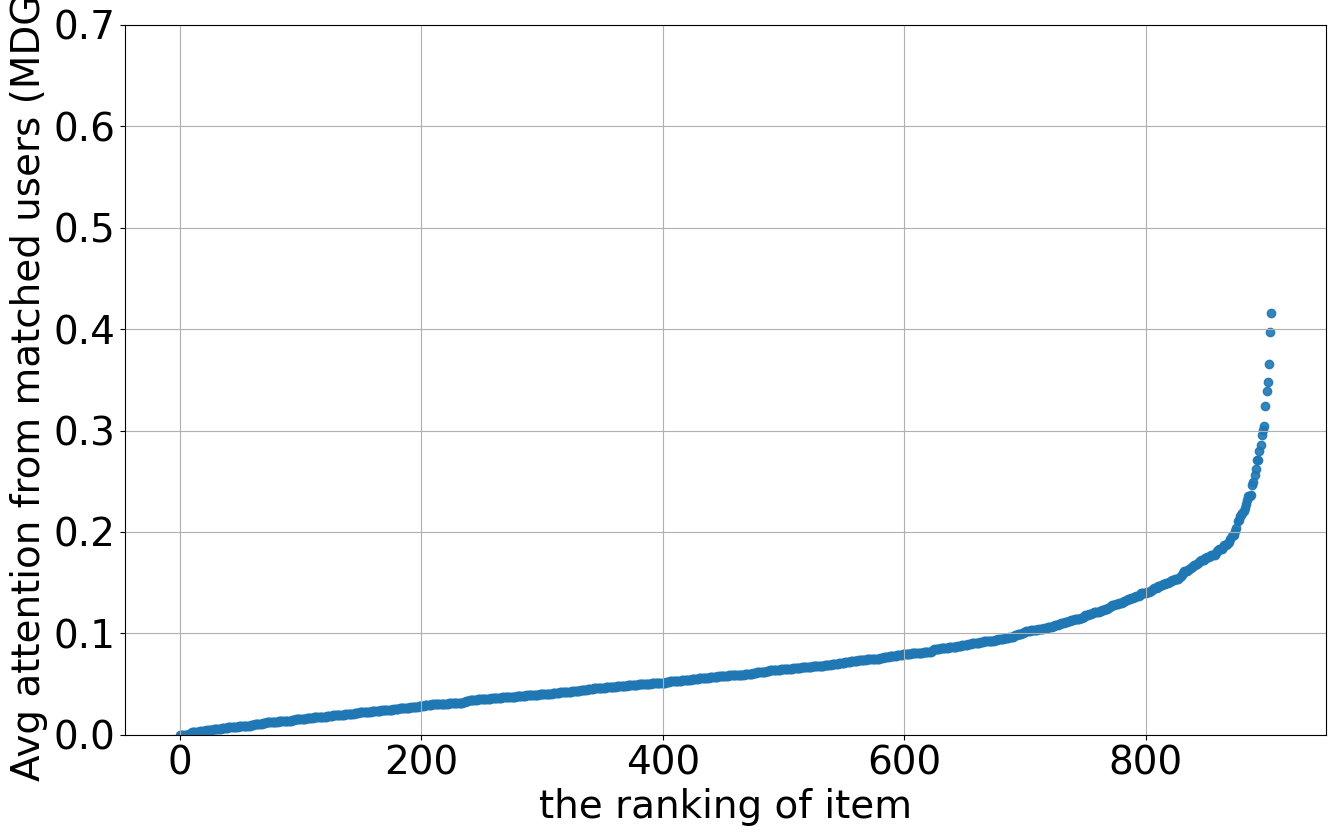

In [16]:
# ploting
plt.rcParams.update({'font.size': 28})
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 9))

axes.scatter(np.arange(len(item_avg_attention)), np.sort(item_avg_attention), alpha=0.9, label='cold items', marker='o')

axes.set_ylabel('Avg attention from matched users (MDG)')
axes.set_xlabel('the ranking of item')
# axes.legend()
axes.grid(True)
axes.set_ylim(0., 0.7)


fig.tight_layout()
fig.patch.set_facecolor('white')
plt.show()